In [1]:
import importlib
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [3]:
os.chdir(os.getcwd() + '/src/')
os.getcwd()
import utils as utils
import gmm as GMM

In [4]:
test_rng: np.random.Generator = np.random.default_rng(0)
k = 2
dim = 2

def reload():
    importlib.reload(GMM)
    importlib.reload(utils)

[[4.21459465 3.68580679]
 [4.84104223 3.51909655]]


<AxesSubplot:>

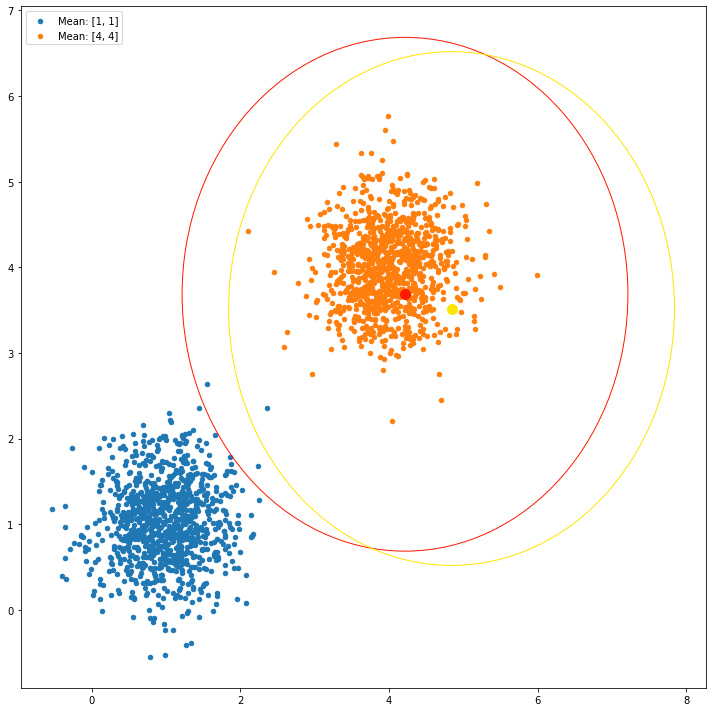

In [21]:
cluster_means = [
    [1, 1],
    [4, 4],
]
initial_data, fig, ax = utils.generate_clustered_data(dim, k, cluster_means, num_points_per_cluster=1000, plot=True, spread_factor=0.05)
shuffle_data = test_rng.permutation(initial_data)
gmm_init_data = shuffle_data[:k]
print(gmm_init_data)
gmm = GMM.GMM(0, 2)
gmm.initialize(gmm_init_data)
utils.plot_gaussians(gmm.means, gmm.covariances, ax)

In [7]:
gmm.log_likelihood(shuffle_data)

-5778.948567197453

In [8]:
nb_iter = 10
batch_size = 100
for i in range(nb_iter):
    print(f'Current ll {gmm.log_likelihood(shuffle_data)}.')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    print(f'Coefficients are {gmm.coefficients}; Means are {gmm.means}')
    print(f'Maxima in covs are {[np.max(c) for c in gmm.covariances]}')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    before = gmm.log_likelihood(samples)
    gmm.online_EM(samples, gamma=0.01)
    after = gmm.log_likelihood(samples)
    print(f'--------- ll shifted from {before} to {after} ----------')

Current ll -5778.948567197453.
Coefficients are [0.5 0.5]; Means are [[3.41578027 3.77181582]
 [1.01084703 0.54976185]]
Maxima in covs are [1.0, 1.0]
--------- ll shifted from -289.52477901503096 to -222.94719417626735 ----------
Current ll -4526.78699596269.
Coefficients are [0.49222922 0.50777078]; Means are [[3.75144096 3.95704917]
 [1.07300373 0.88109476]]
Maxima in covs are [0.3968051483919964, 0.3410121534938241]
--------- ll shifted from -228.9774787722774 to -202.89283812351408 ----------
Current ll -4152.034226080097.
Coefficients are [0.47894638 0.52105362]; Means are [[3.87603759 4.0181379 ]
 [0.92394142 0.91272426]]
Maxima in covs are [0.2712826558595549, 0.31017036349589616]
--------- ll shifted from -199.7658475974588 to -191.52399299830515 ----------
Current ll -4038.7413836969117.
Coefficients are [0.47159681 0.52840319]; Means are [[3.89902626 4.03743447]
 [0.91972912 0.92456067]]
Maxima in covs are [0.2444701167111468, 0.23586899693393926]
--------- ll shifted from -2

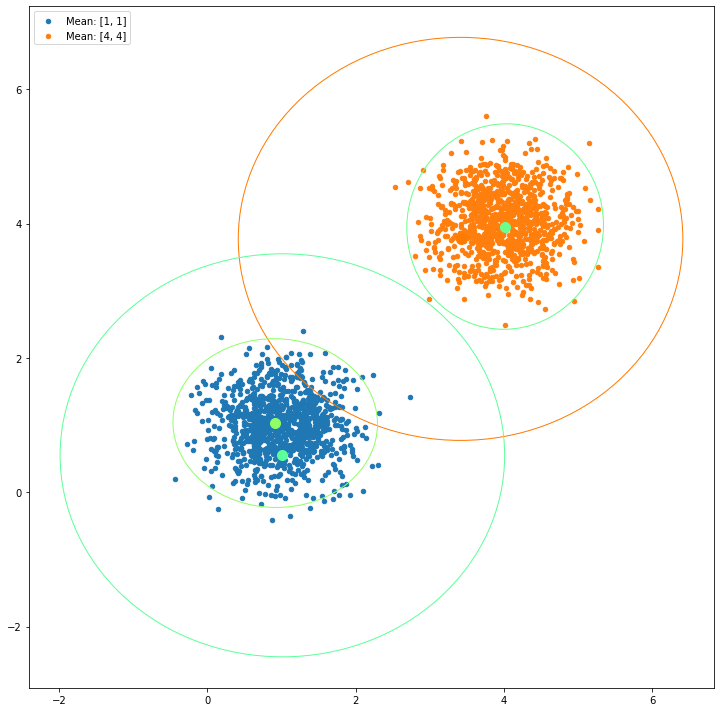

In [9]:
utils.plot_gaussians(gmm.means, gmm.covariances, ax)
fig

## TEST GMM IN HIGHER DIMENSIONS

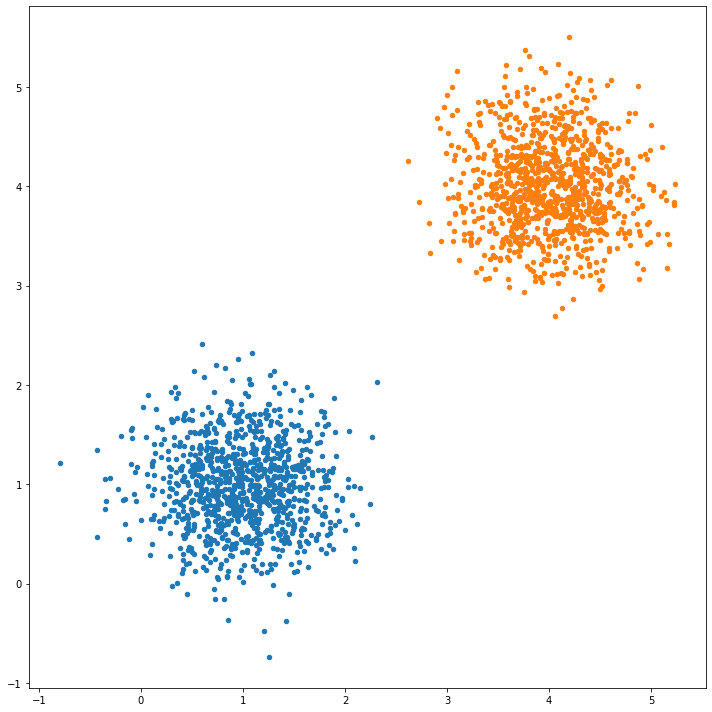

In [87]:
import tqdm
test_rng: np.random.Generator = np.random.default_rng(0)
cluster_means = [
    [1, 1],
    [4, 4],
]
initial_data, fig, ax = utils.generate_clustered_data(dim, k, cluster_means, num_points_per_cluster=1000, plot=True, spread_factor=0.05, rng=test_rng)
shuffle_data = test_rng.permutation(initial_data)

In [88]:
def concatenate_data(data: np.ndarray) -> np.ndarray:
    data_concat = []
    for i in range(len(data) - 1):
        data_concat.append(np.hstack([data[i], data[i+1]]))
    return np.array(data_concat)

concat_data = concatenate_data(shuffle_data)
concat_data.shape

(1999, 4)

In [89]:
# solve the clustering problem with K-means clustering method
from sklearn.cluster import KMeans

training_data = concat_data
kmeans = KMeans(n_clusters=4, random_state=0).fit(training_data)
# kmeans.labels_
kmeans.cluster_centers_

array([[3.99067223, 4.01228666, 0.9908468 , 0.97920931],
       [0.99190083, 0.97875034, 4.00225422, 3.99798044],
       [3.99182659, 4.00091211, 3.97971219, 4.01581345],
       [0.97994553, 0.99812768, 0.98244776, 0.99618568]])

In [90]:
# solve the clustering problem with the GMM
gmm = GMM.GMM(0, 4)
gmm.initialize(concat_data[:4])
print(gmm.means)
num_iterations = 20
batch_size = 500
# fails with gamma = 0.01
# gamma = 0.01
gamma = 0.05
ll = [gmm.log_likelihood(concat_data)]
i = 0
for _ in tqdm.tqdm(range(num_iterations)):
    samples = concat_data[test_rng.choice(len(concat_data), size=batch_size)]
    gmm.online_EM(samples, gamma=gamma)
    ll.append(gmm.log_likelihood(concat_data))
    i += 1

[[0.35209585 1.6631099  1.71380809 0.44130742]
 [1.71380809 0.44130742 0.67504939 0.45824195]
 [0.67504939 0.45824195 1.24615729 1.03929885]
 [1.24615729 1.03929885 1.1635392  0.92728161]]


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


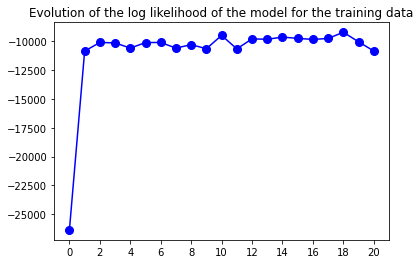

In [91]:
fig, ax = plt.subplots()
color = 'blue'
ax.plot(np.arange(len(ll)), ll, color=color)
for j, l in enumerate(ll):
    ax.plot(j, l, marker='o', markersize=8, markeredgecolor=color, markerfacecolor=color)
ax.set_xticks(np.arange(len(ll), step=2))
ax.set_title('Evolution of the log likelihood of the model for the training data')
print()

In [92]:
print(gmm.means)

[[1.2452515  1.08926328 1.2296712  1.1115197 ]
 [0.96927833 1.29055407 4.09614147 4.01503995]
 [3.61790958 3.79975593 1.33350846 0.94562227]
 [3.87746058 3.9069795  4.12238531 4.16204266]]


In [86]:
print(kmeans.cluster_centers_)

[[3.99067223 4.01228666 0.9908468  0.97920931]
 [0.99190083 0.97875034 4.00225422 3.99798044]
 [3.99182659 4.00091211 3.97971219 4.01581345]
 [0.97994553 0.99812768 0.98244776 0.99618568]]


Conclusion is that the update parameter $\gamma$ can impede the model's ability to solve the clustering problem.